# CausalML - Analysing AB Test Results

## 1. Introduction
In this blog I’ll take you through the analysis of A/B test results using CausalML package. It is an easy and powerful package for causal inference that takes into account propensity matching, conditional probabilities and much more. Here, I’ll use a dataset with ingrained bias to show how you can still estimate the treatment effect without extensive pre-processing and exploratory analysis. You can download the data here and get full code in my github repo. Thanks to this repo for initial data.

## 2. Experiments in Marketing
Experiments are a staple of causal reasoning and are widely used in many disciplines. In digital marketing, A/B test refers to the experiment design that splits the user base into two groups - control and treatment. Treatment group gets exposed to a new feature/design/offer/etc. while the control group’s experience stays the same. The behaviours of two groups are monitored and compared with regards to a specific metric (e.g. conversion rate). If the treatment group has a statistically better performance, then the experiment is considered a success and the feature gets rolled out to the entire user base.

Let’s imagine a scenario: we want to know whether serving a website with localised translations is better than our current version of one-size-fits-all approach. We decide to run an A/B test and track the conversions of two groups. We will analyse the data that we’ve gathered so far to see the effect of our proposed change.

## 3. Data Preprocessing
This dataset is split into two tables, which we'll need to join. Also, most of the variables need to be transformed to serve as input into the ML model of choice (here it's LightGBM). To get the data ready, we'll do the following pre-processing steps:

1. Get seasonal variables from date
2. Join two dataset
3. Drop Spain because it has no localised translation
4. Transform categorical into numerical

In [1]:
# Imports
# Data preprocessing
import pandas as pd
import numpy as np

# Uplift Modelling
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from causalml.inference.meta import BaseXClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\admin 247\anaconda3\envs\causal-ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
main = pd.read_csv('D:\\Kerja\\Merkle\\causalml\\docs\\examples\\data\\test_table.csv')
users = pd.read_csv('D:\\Kerja\\Merkle\\causalml\\docs\\examples\\data\\user_table.csv')

In [3]:
main.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [4]:
users.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [5]:
# PREPROCESSING
# Adding seasonal variables
main['date'] = pd.to_datetime(main.date, format='%Y-%m-%d')
main['month'] = main['date'].apply(lambda x: x.month)
main['day_month'] = main['date'].apply(lambda x: x.day)
# Dropping date column
main = main.drop('date', axis=1)

In [6]:
# Joining user data
main = main.merge(users,left_on='user_id', right_on='user_id', how='inner')

In [7]:
main.head()

,user_id,source,device,browser_language,ads_channel,browser,conversion,test,month,day_month,sex,age,country
0,315281,Direct,Web,ES,NaN,IE,1,0,12,3,M,32,Spain
1,497851,Ads,Web,ES,Google,IE,0,1,12,4,M,21,Mexico
2,848402,Ads,Web,ES,Facebook,Chrome,0,0,12,4,M,34,Spain
3,290051,Ads,Mobile,Other,Facebook,Android_App,0,1,12,3,F,22,Mexico
4,548435,Ads,Web,ES,Google,FireFox,0,1,11,30,M,19,Mexico


In [8]:
# Drop Spain country
main = main.loc[main['country'] != 'Spain', :]

In [9]:
# Transforming to numerical
main['ads_channel']=main['ads_channel'].fillna('direct')
categorical = ['source','device','browser_language',
               'ads_channel', 'browser', 'sex', 'country']

for c in categorical:
    main[c] = LabelEncoder().fit_transform(main[c])
    main[c] = main[c].astype('category')

In [10]:
main.head()

,user_id,source,device,browser_language,ads_channel,browser,conversion,test,month,day_month,sex,age,country
1,497851,0,1,1,2,3,0,1,12,4,1,21,9
3,290051,0,0,2,1,0,0,1,12,3,0,22,9
4,548435,0,1,1,2,2,0,1,11,30,1,19,9
5,540675,1,0,1,5,0,0,1,12,3,0,22,15
6,863394,2,0,2,5,0,0,0,12,4,1,35,9


## 4. Initial Analysis
Columns in the dataframe above are:
- Test - 1 if a person is part of a test group, 0 if a user is part of control group
- Conversion - our outcome variable
- Everything else is context for a particular conversion (potential confounders)

If the experiment was properly set-up, we'd be able to directly compare the conversion rates of two groups, and conclude if the experiment was a success

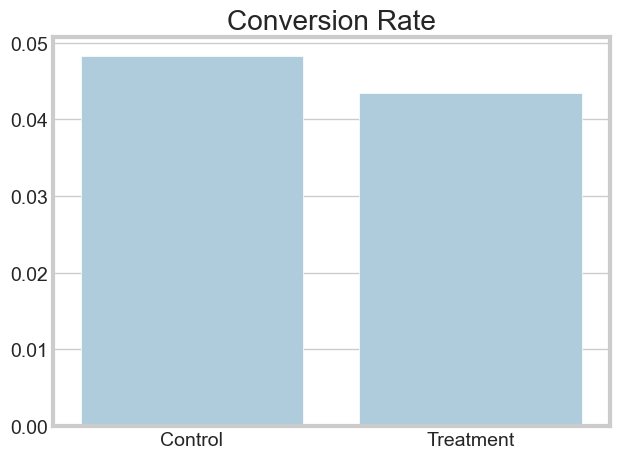

Difference between Control and Treatment -0.00488


In [11]:
sns.set_style('whitegrid')
sns.barplot(x = ['Control', 'Treatment'], y = main.groupby('test')['conversion'].mean().values)
plt.title('Conversion Rate')
plt.show()
print(f'Difference between Control and Treatment { np.round(main.groupby("test")["conversion"].mean()[1] - main.groupby("test")["conversion"].mean()[0], 5)}')

From this it follows that the conversion rate is smaller by 0.4% in treatment group. However, upon taking a closer look at the data, you might begin to notice some irregularities. For example, by grouping the data by Country and Test columns, you will see that countries with indices 0 to 14 have much Treatment observations than Control. Tis might be an indication of **selection bias**, so we can't compare two means directly. Luckily, CausalML help us to identify this type of inconsstencies and gives us a more unbiased result.

[CausalML](https://causalml.readthedocs.io/en/latest/index.html) is a Python package that provides access to a suite of algorithms dedicated to uplift modelling and causal inference. It has a range of meta-learner algorithms (meaning that they can take any ML model as base) that estimate Average Treatment Effect (ATE) and Conditional Average Treatment Effect (CATE).

In this blog, I'll focus on estimating ATE because this is what the A/B Testing is all about, but I'll definietly cover the CATE estimation later. 

CausalML so far has 4 meta-algorithms:
- S-Learner
- T-Learner
- X-Learner
- R-Learner

Here, I will be using X-Learner because it is one of the most recent developments in causal inference, and because it excels with imbalanced data (like in our case). The algorithm works in 3 stages:
1. Train 2 ML models - the first is for users who have converted, and the second one is for users who haven't
2. Based on the difference between the observed outcome and predicted outcome (using reverse outcome models) train another 2 ML Models
3. Run the observations through final two models and get a weighted average of CATE using the propensity scores as weights

I know that I've skimmed through the methodology part, but the [official docummentation](https://causalml.readthedocs.io/en/latest/methodology.html#meta-learner-algorithms) and the actuap paper by [Künzel et al. (2019)](https://arxiv.org/abs/1706.03461) explain the methodology quite nicely, so make sure to read it

## 5. CausalML - Data Prep
There are a few steps prior to modelling with CausalML
1. Separate variables into Treatment, Outcome, and Confounders
2. Get Propensity Scores

In [12]:
# Treatment
treatment = main['test']
treatment = np.array(['treatment' if val==1 else 'control' for val in treatment])
pd.Series(treatment).value_counts()

treatment    215774
control      185311
Name: count, dtype: int64

In [13]:
# Outcome
y = main['conversion']
y.value_counts()

conversion
0    382769
1     18316
Name: count, dtype: int64

In [14]:
# Confounders
X = main.drop(['user_id', 'conversion', 'test'], axis = 1)

*Note: propensity scoring can be done automatically in the package (by not providing the propensity scores) but I though that it would be nice to cover to understand the algorithms a bit better*

Propensity model is build by treating the Treatment variable as dependent, and Confounders as independent variables. If we achieve a model with AUC score larger than 0.5 (random guessing), we can say that we have some sort of sampling bias

In [15]:
# Propensity Model
prop_model = LGBMClassifier(colsample_bytree=0.8, subsample=0.8, n_estimators=300)
print(cross_val_score(prop_model, X, treatment, cv=5, scoring='roc_auc').mean())

[LightGBM] [Info] Number of positive: 172619, number of negative: 148249
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 320868, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.537975 -> initscore=0.152194
[LightGBM] [Info] Start training from score 0.152194
[LightGBM] [Info] Number of positive: 172619, number of negative: 148249
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 320868, number of used features: 10
[LightGBM] [Info

Model achieves AUC of 0.57, which makes it useful in evaluating the test outcome

In [16]:
# Fitting the model
prop_model.fit(X, treatment)

[LightGBM] [Info] Number of positive: 215774, number of negative: 185311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 401085, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.537976 -> initscore=0.152196
[LightGBM] [Info] Start training from score 0.152196


LGBMClassifier(colsample_bytree=0.8, n_estimators=300, subsample=0.8)

In [21]:
# Getting propensity scores
prop_scores = prop_model.predict_proba(X)

### 6. X-Learner ATE Estimation
Now that the data is ready and propensity scores are estimated, the actual ATE estimation takes onlu a few seconds. Key things to remember here:
1. Choose the right class of meta-learner depending on your task **Regressor** and **Classifier**
2. **learner** parameter has to be consistent with your meta-learner class
3. If you use Classifier meta-learner, you need to provide **effect learners** which are **regressors**

In [23]:
# Fitting the X-meta learner
learner_X = BaseXClassifier(LGBMClassifier(colsample_bytree=0.8, num_leaves=50, n_estimators=200),
                            control_effect_learner=LinearRegression(),
                            treatment_effect_learner=LinearRegression(),
                            control_name='control')

# Getting the average treatment effect with upper and lower bounds
ate_x, ate_x_lb, ate_x_ub = learner_X.estimate_ate(X=X, treatment=treatment, y=y, p=prop_scores[:, 1])
print(ate_x, ate_x_lb, ate_x_ub)

[LightGBM] [Info] Number of positive: 8949, number of negative: 176362
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 185311, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048292 -> initscore=-2.980997
[LightGBM] [Info] Start training from score -2.980997
[LightGBM] [Info] Number of positive: 9367, number of negative: 206407
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 95
[LightGBM] [Info] Number of data points in the train set: 215774, number of used features: 10
[LightGBM] [Info] [b

The output should be that the average effect of our change is about 0.0. This means that there is **no clear effect** of our experiment on the propensity to convert which is in contrast to our previous conclusion

### 7. Summary
Overall, our initial conclusion that the change has negative effect was wrong. We were able to get a more unbiased estimate of treatment effect using X meta-learner from CausalML package. Let me know your thoughts and if you want me to cover any other topics in testing and causal inference.